In [18]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import sys
import random
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

grid_size = 100
test_states = torch.tensor([[50.,50.]])
test_scores = torch.tensor([-150.0])

baseline_states = torch.tensor([[ 0,  7],
        [ 1, 41],
        [43,  0],
        [83, 84]])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
def plot_function(fn, scatter_markers=None, output_index=-1):
    # fn: function to plot
    # output_index: -1 if the output of the function is a single value; if the outputs are tuples index of the output that should be plotted
    xi = np.arange(0,1,1/grid_size)
    yi = np.arange(0,1,1/grid_size)
    grid = np.array(np.meshgrid(xi,yi))
    grid_flat = torch.tensor(grid.T, dtype=torch.float64).reshape(-1,2).to(device)
    res = fn(grid_flat)
    if output_index >= 0:
        res = res[output_index]
    res = res.to("cpu")
    fig, ax = plt.subplots(nrows=1)
    # ax.matshow(res)
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py
    cntr = ax.contourf(xi, yi, res.reshape(int(len(res)**(1/2)),int(len(res)**(1/2))), levels=50)
    fig.colorbar(cntr, ax=ax)
    if scatter_markers is not None:
        scatter_markers = scatter_markers/grid_size
        plt.scatter(x=scatter_markers[:,0], y=scatter_markers[:,1], c="red", marker="x")
    return fig, ax

In [29]:
# dataset
from dataset.dataset import Branin_DatasetHandler
dataset_handler = Branin_DatasetHandler(train_path="./storage/branin/data_train.csv", train_fraction=1.0, float_precision=64)

# testing dataset
dataset_handler.update_dataset(test_states, test_scores)
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
train_loader, test_loader = dataset_handler.get_dataloader()
for X, y in train_loader:
    print(X, y)

TODO: check what format the states and scores have and make sure that everything is stored in the same format
tensor([[0.0000e+00, 7.0000e+00],
        [1.0000e+00, 4.1000e+01],
        [4.3000e+01, 0.0000e+00],
        [8.3000e+01, 8.4000e+01],
        [5.0000e-05, 5.0000e-05]]) tensor([-272.7960, -122.4223,  -25.6283, -141.9208, -150.0000])
(tensor([[0.0000e+00, 7.0000e-02],
        [1.0000e-02, 4.1000e-01],
        [4.3000e-01, 0.0000e+00],
        [8.3000e-01, 8.4000e-01],
        [5.0000e-07, 5.0000e-07]]), tensor([0.0000, 0.6084, 1.0000, 0.5295, 0.4968]))
tensor([[1.0000e-02, 4.1000e-01],
        [0.0000e+00, 7.0000e-02],
        [5.0000e-07, 5.0000e-07],
        [4.3000e-01, 0.0000e+00],
        [8.3000e-01, 8.4000e-01]]) [tensor(0.6084), tensor(0.), tensor(0.4968), tensor(1.), tensor(0.5295)]


tensor([0.3593], device='cuda:0', dtype=torch.float64) tensor([0.1835], device='cuda:0', dtype=torch.float64)


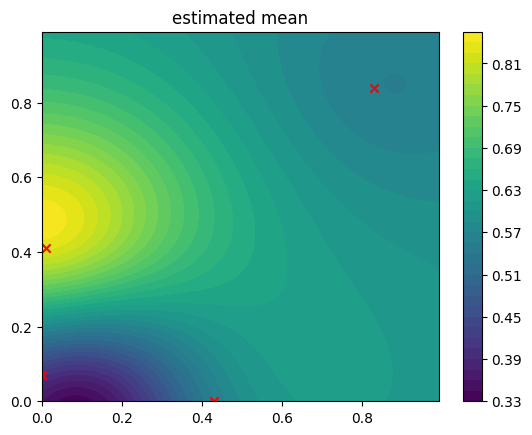

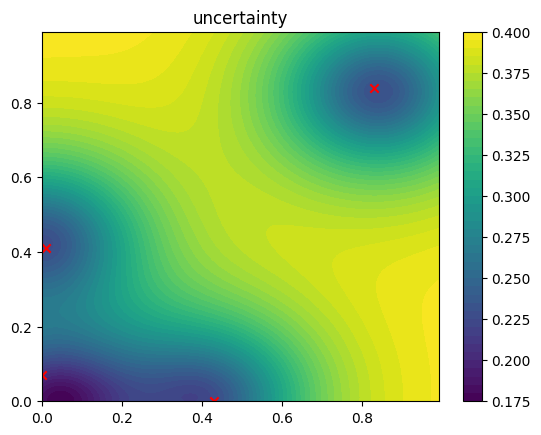

In [30]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor
surrogate = SingleTaskGPRegressor(device=device)
surrogate.fit(dataset_handler.train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states/grid_size)
print(preds_mean, preds_var)

# plot surrogate function
plot_function(surrogate.get_predictions, scatter_markers=baseline_states, output_index=0)
plt.title("estimated mean")
plt.show()

plot_function(surrogate.get_predictions, scatter_markers=baseline_states, output_index=1)
plt.title("uncertainty")
plt.show()

In [22]:
# Sampler (e.g., GFlowNet, or Random Sampler)


In [23]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

abs_config_dir=os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
from utils.logger import Logger
logger = Logger(
    config=OmegaConf.create(), 
    **config_logger
)

{'do': {'online': True, 'times': True}, 'ckpts': {'policy': {'period': 5000}, 'regressor': {'period': 10}}, 'train': {'period': 1}, 'test': {'period': -1, 'n': 1, 'first_it': True, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}}, 'oracle': {'period': -1, 'k': [1, 10, 100]}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'data': 'data', 'overwrite': True}, 'lightweight': False, 'progress': True, 'debug': False, 'project_name': 'MF-AL-GFN', 'tags': ['branin', 'sf']}


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


tensor([ -35.8619, -185.1583, -282.1307, -167.8297], device='cuda:0',
       dtype=torch.float64)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

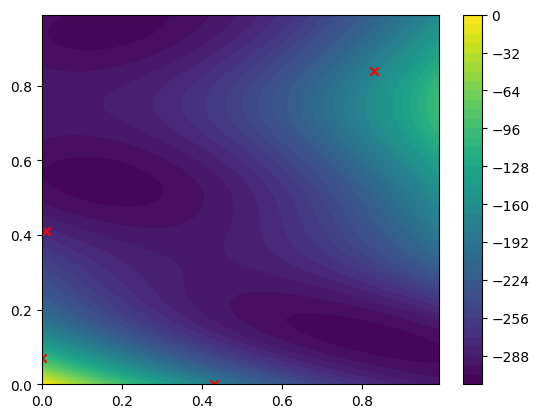

In [24]:
# Oracle
from gflownet.proxy.box.branin import Branin
oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=64)

# testing oracle
print(oracle(baseline_states.to(device).clone()/grid_size))

# plot oracle function
plot_function(oracle, scatter_markers=baseline_states)

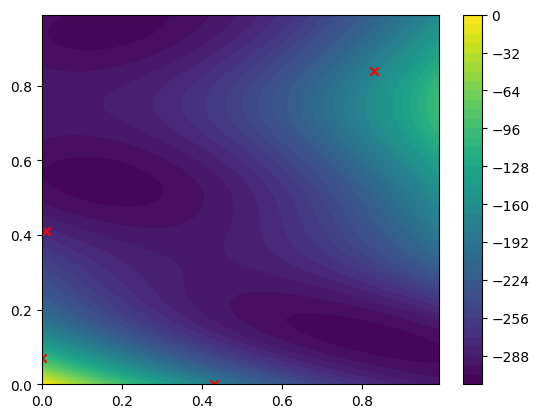

In [ ]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer, 
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)